In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Crema/Crema.zip' -d 'Crema'

Streaming output truncated to the last 5000 lines.
  inflating: Crema/1031_DFA_DIS_XX.wav  
  inflating: Crema/1031_DFA_FEA_XX.wav  
  inflating: Crema/1031_DFA_HAP_XX.wav  
  inflating: Crema/1031_DFA_NEU_XX.wav  
  inflating: Crema/1031_DFA_SAD_XX.wav  
  inflating: Crema/1031_IEO_ANG_HI.wav  
  inflating: Crema/1031_IEO_ANG_LO.wav  
  inflating: Crema/1031_IEO_ANG_MD.wav  
  inflating: Crema/1031_IEO_DIS_HI.wav  
  inflating: Crema/1031_IEO_DIS_LO.wav  
  inflating: Crema/1031_IEO_DIS_MD.wav  
  inflating: Crema/1031_IEO_FEA_HI.wav  
  inflating: Crema/1031_IEO_FEA_LO.wav  
  inflating: Crema/1031_IEO_FEA_MD.wav  
  inflating: Crema/1031_IEO_HAP_HI.wav  
  inflating: Crema/1031_IEO_HAP_LO.wav  
  inflating: Crema/1031_IEO_HAP_MD.wav  
  inflating: Crema/1031_IEO_NEU_XX.wav  
  inflating: Crema/1031_IEO_SAD_HI.wav  
  inflating: Crema/1031_IEO_SAD_LO.wav  
  inflating: Crema/1031_IEO_SAD_MD.wav  
  inflating: Crema/1031_IOM_ANG_XX.wav  
  inflating: Crema/1031_IOM_DIS_XX.wav  
  infl

In [ ]:
import os
import re
from tqdm.notebook import tqdm as tq
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
from IPython.core.display import display
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import regularizers, initializers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import MaxPool1D, MaxPooling1D, AveragePooling1D, Activation
import itertools

In [ ]:
def create_labeled_dataset():
  label_list = []
  for wav in os.listdir('Crema'):
    filename_list = wav.partition(".wav")[0].split("_")
    label = filename_list[2]
    if label == 'SAD':
      label_list.append(("sad", 'Crema' + "/" + wav))
    if label == 'ANG':
      label_list.append(("angry", 'Crema' + "/" + wav))
    if label == 'DIS':
      label_list.append(("disgust", 'Crema' + "/" + wav))
    if label == 'FEA':
      label_list.append(("fear", 'Crema' + "/" + wav))
    if label == 'HAP':
      label_list.append(("happy", 'Crema' + "/" + wav))
    if label == 'NEU':
      label_list.append(("neutral", 'Crema' + "/" + wav))
  Crema_df = pd.DataFrame().from_dict(label_list)
  Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)
  return Crema_df

Crema_df = create_labeled_dataset()
Crema_df.head()

,Emotion,Path
0,disgust,Crema/1082_MTI_DIS_XX.wav
1,sad,Crema/1007_IWW_SAD_XX.wav
2,neutral,Crema/1047_TSI_NEU_XX.wav
3,angry,Crema/1084_IEO_ANG_MD.wav
4,sad,Crema/1049_IOM_SAD_XX.wav


In [ ]:
Crema_df['Emotion'].value_counts()

fear       1271
disgust    1271
happy      1271
angry      1271
sad        1271
neutral    1087
Name: Emotion, dtype: int64

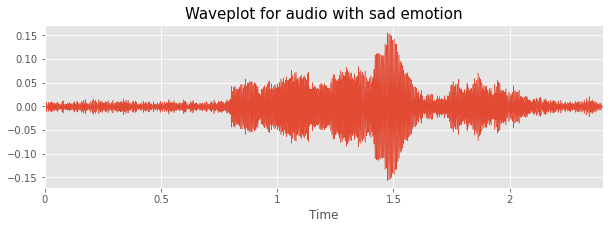

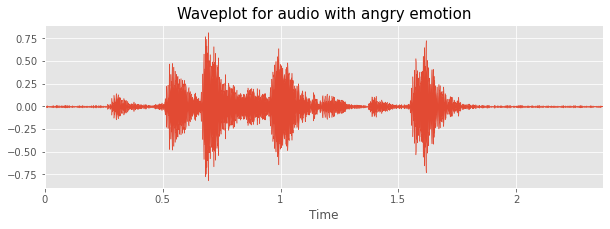

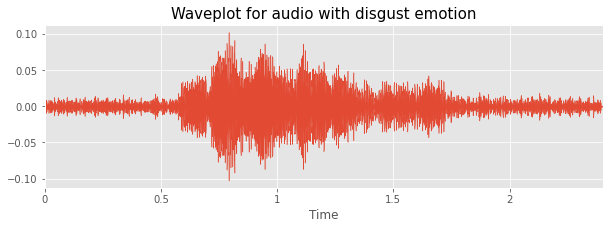

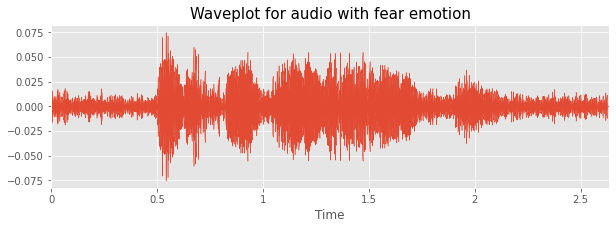

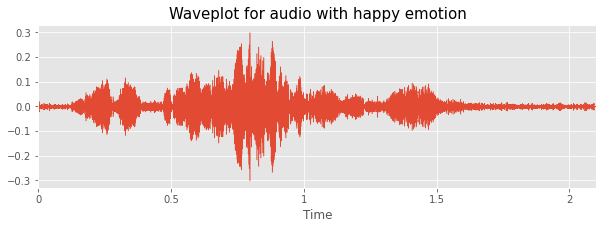

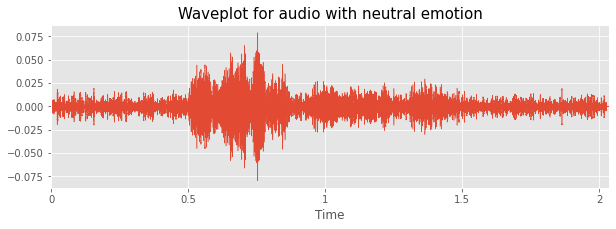

In [ ]:
%matplotlib inline
plt.style.use("ggplot")
def create_waveplot(data, Fs, emotion):
  plt.figure(figsize=(10, 3))
  plt.title(f'Waveplot for audio with {emotion} emotion', size=15)
  librosa.display.waveplot(data, sr=Fs)
  plt.show()
  print()

def load_and_plot_audio(df, emotion):
  path = np.array(df.Path[df.Emotion == emotion])[1]
  data, sampling_rate = librosa.load(path)
  create_waveplot(data, sampling_rate, emotion)
  display(Audio(path))

load_and_plot_audio(Crema_df, 'sad')
load_and_plot_audio(Crema_df, 'angry')
load_and_plot_audio(Crema_df, 'disgust')
load_and_plot_audio(Crema_df, 'fear')
load_and_plot_audio(Crema_df, 'happy')
load_and_plot_audio(Crema_df, 'neutral')

In [ ]:
def split_data_into_train_val_test(dataset, labels, test_size, val_size, ismel = False):
  '''
  makes the split of the dataset into train, val, and test sets.
  test_size: is percentage/100
  val_size: is percentage/100 of the train set after splitting the dataset into train and test sets
  returns a standardized version of X_train, X_val and X_test with their respective class labels (Y_train, Y_val, Y_test)
  '''
  X_train, X_test, y_train, y_test = train_test_split(dataset,
                                                      labels,
                                                      random_state=12,
                                                      test_size=test_size,
                                                      shuffle=True)
  
  X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                    y_train,
                                                    random_state=12,
                                                    test_size=val_size,
                                                    shuffle=True)
  if ismel == False:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)[..., np.newaxis]
    X_test = scaler.transform(X_test)[..., np.newaxis]
    X_val = scaler.transform(X_val)[..., np.newaxis]

  
  return X_train, X_val, X_test, y_train, y_val, y_test

# Making new features For Conv1D

## Helper Functions in feature extraction

In [ ]:
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)     
def stretch(data, rate=1):
    return librosa.effects.time_stretch(data, rate) 

In [ ]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
  result = np.array([])
  result = np.hstack((result,zcr(data, frame_length, hop_length),rmse(data)))
  return result
  
def get_features(path, duration=2.5, offset = 0.6,augment=False):
  '''
    The function extracts the required features from the original audio files, Then adds noise, pitch  to all the dataset and extracts
    features from the noisy audio
  '''
  data, sample_rate = librosa.load(path, duration = duration, offset = offset)
  
  res1 = extract_features(data, np.array(sample_rate))
  
  result = np.array(res1)
  if augment:
  #data_augmentation
    noise_data = noise(data)

    res2=extract_features(noise_data, np.array(sample_rate))
  
    result = np.vstack((result, res2))
  
    stretched = stretch(data)

    pitched = pitch(stretched , sample_rate)
  
    res3 = extract_features(pitched,np.array(sample_rate))
  
    result = np.vstack((result,res3))
  
  return result

def get_data_features(df,augment,):
  data_elements, data_labels = [], []
  
  print("Feature processing...")
  for path, emotion, ind, i in zip(df.Path, df.Emotion, range(df.Path.shape[0]), tq(range(df.Path.shape[0]))):
    
    if augment==False:
      features = get_features(path)
      data_elements.append(features)
      data_labels.append(emotion)
    else:
      feature = get_features(path,augment=augment)
      for ele in feature:
        data_elements.append(ele)
        data_labels.append(emotion)
  print("Done.")
  return data_elements, data_labels

def save_features_to_csv_then_return(data_elements, data_labels, path):
  features_path = path
  new_Crema_df = pd.DataFrame(data_elements)
  new_Crema_df["labels"] = data_labels
  new_Crema_df = new_Crema_df.fillna(new_Crema_df.mean())
  new_Crema_df.to_csv(features_path, index=False)
  return new_Crema_df

def retrive_features_from_csv(path):
  new_Crema_df = pd.read_csv(path)
  return new_Crema_df

def prepare_data_and_labels(new_Crema_df):
  new_Crema_df = new_Crema_df.fillna(0)
  data_elements = new_Crema_df.drop(labels="labels", axis=1)
  data_labels = new_Crema_df["labels"]
  labels_encoder = LabelEncoder()
  labels_encoded = labels_encoder.fit_transform(data_labels)
  data_labels = np_utils.to_categorical(labels_encoded)
  print(labels_encoder.classes_)
  print(data_labels)
  return data_elements, data_labels

## Performing feature extraction to get the features for the Conv1D model

### Splitting before Augmentation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Crema_df.Path, Crema_df.Emotion, shuffle = True, random_state = 12, test_size = 0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle = True, random_state = 12, test_size =  0.05)
c_df = pd.DataFrame(X_train)
c_df["Emotion"] = y_train
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((4948,), (2233,), (261,), (4948,), (2233,), (261,))

In [ ]:
data_elements, data_labels = get_data_features(c_df,True)
new_Crema_df = save_features_to_csv_then_return(data_elements, data_labels, "/content/drive/MyDrive/Assign_Features/Train.csv")

Feature processing...


Done.


In [ ]:
X_train, y_train = prepare_data_and_labels(new_Crema_df)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [ ]:
t_df = pd.DataFrame(X_test)
t_df["Emotion"] = y_test
v_df = pd.DataFrame(X_val)
v_df["Emotion"] = y_val

In [ ]:
X_val, y_val = get_data_features(v_df,augment=False)
new_Crema_df = save_features_to_csv_then_return(X_val, y_val, "/content/drive/MyDrive/Assign_Features/val.csv")
X_val, y_val = prepare_data_and_labels(new_Crema_df)

Feature processing...


Done.
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [ ]:
X_test, y_test = get_data_features(t_df,augment=False)
new_Crema_df = save_features_to_csv_then_return(X_test, y_test, "/content/drive/MyDrive/Assign_Features/Test.csv")
X_test, y_test = prepare_data_and_labels(new_Crema_df)

Feature processing...


Done.
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]


#### Retrive the features

In [ ]:
#augmentation on Val & Train
new_Crema_df = retrive_features_from_csv('/content/drive/MyDrive/Assign_Features/Train3.csv')
data_elements, data_labels = prepare_data_and_labels(new_Crema_df)
X_train, X_val, y_train, y_val = train_test_split(data_elements, data_labels, shuffle = True, random_state = 12, test_size =  0.05)

new_Crema_df = retrive_features_from_csv('/content/drive/MyDrive/Assign_Features/Test.csv')
X_test, y_test = prepare_data_and_labels(new_Crema_df)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]


In [ ]:
#train only
new_Crema_df = retrive_features_from_csv('/content/drive/MyDrive/Assign_Features/Train.csv')
X_train, y_train = prepare_data_and_labels(new_Crema_df)
new_Crema_df = retrive_features_from_csv('/content/drive/MyDrive/Assign_Features/val.csv')
X_val, y_val = prepare_data_and_labels(new_Crema_df)
new_Crema_df = retrive_features_from_csv('/content/drive/MyDrive/Assign_Features/Test.csv')
X_test, y_test = prepare_data_and_labels(new_Crema_df)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [ ]:
from sklearn import utils
X_train, y_train = utils.shuffle(X_train, y_train, random_state=14)
X_val, y_val = utils.shuffle(X_val, y_val, random_state=14)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)[..., np.newaxis]
X_test = scaler.transform(X_test)[..., np.newaxis]
X_val = scaler.transform(X_val)[..., np.newaxis]

In [ ]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((14844, 109, 1),
 (2233, 109, 1),
 (783, 109, 1),
 (14844, 6),
 (2233, 6),
 (783, 6))

### Without Augmentation

In [ ]:
data_elements, data_labels = get_data_features(Crema_df, augment = False)
new_Crema_df = save_features_to_csv_then_return(data_elements, data_labels, "/content/drive/MyDrive/Assign_Features/featuresConv1D.csv")
data_elements, data_labels = prepare_data_and_labels(new_Crema_df)
X_train, X_val, X_test, y_train, y_val, y_test = split_data_into_train_val_test(data_elements, data_labels, test_size=0.3, val_size=0.05, ismel = False)

Feature processing...


Done.
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]]


In [ ]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((14844, 216, 1),
 (2233, 216, 1),
 (261, 216, 1),
 (14844, 6),
 (2233, 6),
 (261, 6))

In [ ]:
new_Crema_df = retrive_features_from_csv('/content/drive/MyDrive/Assign_Features/featuresConv1D22.csv')
data_elements, data_labels = prepare_data_and_labels(new_Crema_df)
X_train, X_val, X_test, y_train, y_val, y_test = split_data_into_train_val_test(data_elements, data_labels, test_size=0.3, val_size=0.05, ismel = False)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


#For MelSpectroGram

In [ ]:
def to_categroical_labels(data_labels):
  labels_encoder = LabelEncoder()
  labels_encoded = labels_encoder.fit_transform(data_labels)
  data_labels = np_utils.to_categorical(labels_encoded)
  print(labels_encoder.classes_)
  print(data_labels)
  return data_labels

##Function to create mel spectrograms

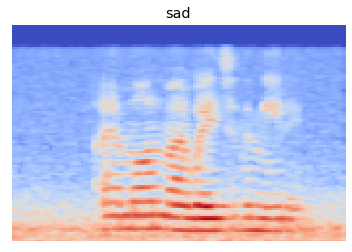

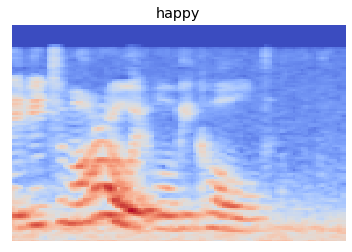

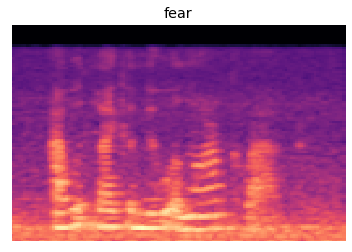

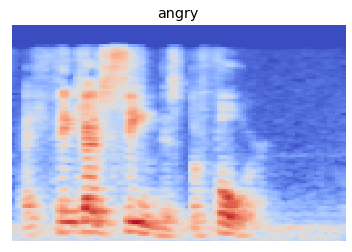

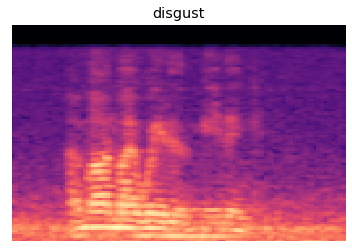

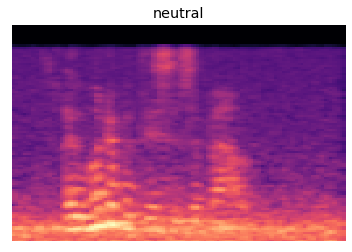

In [ ]:
import cv2
def create_mel_spectrogram(data, sample_rate):
  mel_spectrogram = librosa.feature.melspectrogram(data, sr = sample_rate, n_fft=2048, n_mels=128)
  resized = cv2.resize(mel_spectrogram, (128, 108), interpolation = cv2.INTER_AREA)
  mel_spectrogram_db = librosa.power_to_db(resized)
  melnormalized = librosa.util.normalize(mel_spectrogram_db)
  return melnormalized



def show_random_melSpectrogram_emotion(emotion):
  path = np.array(Crema_df.Path[Crema_df.Emotion == emotion])[1]
  data, sample_rate = librosa.load(path, duration = 2.5, offset = 0.2)
  mel = create_mel_spectrogram(data, sample_rate)
  librosa.display.specshow(mel)
  plt.title(emotion)
  plt.show()


show_random_melSpectrogram_emotion('sad')
show_random_melSpectrogram_emotion('happy')
show_random_melSpectrogram_emotion('fear')
show_random_melSpectrogram_emotion('angry')
show_random_melSpectrogram_emotion('disgust')
show_random_melSpectrogram_emotion('neutral')

In [ ]:
def get_all_mel_spectrograms(df, duration=2.5, offset = 0.2, augment = True):
  data_elements, data_labels = [], []
  for path, emotion, ind in zip(df.Path, df.Emotion, tq(range(df.Path.shape[0]))):
    data, sample_rate = librosa.load(path, duration = duration, offset = offset)
    if augment:
      noise_data = noise(data)
      stretched = stretch(data)
      pitched = pitch(stretched , sample_rate)
      for d in [data, noise_data, pitched]:
        spectrogram = create_mel_spectrogram(d, sample_rate)
        data_elements.append(spectrogram)
        data_labels.append(emotion)
    else:
      spectrogram = create_mel_spectrogram(data, sample_rate)
      data_elements.append(spectrogram)
      data_labels.append(emotion)      
  data_elements = np.asarray(data_elements)
  data_labels = np.asarray(data_labels)
  return data_elements, data_labels

## Without augmentation

In [ ]:
data_elements, data_labels = get_all_mel_spectrograms(Crema_df, augment=False)

In [ ]:
datalabels = to_categroical_labels(data_labels)
X_train, X_val, X_test, y_train, y_val, y_test = split_data_into_train_val_test(data_elements, datalabels, 0.3, 0.05, ismel=True)

X_train = X_train[...,np.newaxis]
X_val = X_val[...,np.newaxis]
X_test = X_test[...,np.newaxis]
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


((4948, 108, 128, 1),
 (2233, 108, 128, 1),
 (261, 108, 128, 1),
 (4948, 6),
 (2233, 6),
 (261, 6))

# Callbacks and visualization functions

In [ ]:
def scheduler(epoch, lr):
    if epoch <= 25:
      return lr
    else:
      return lr * np.exp(-0.1)

def cosine_schedule(epoch, lr):
  total_epochs = 30
  initial_lr = 0.001
  new_lr = 0.5 * initial_lr * (1 + np.cos(epoch*np.pi / total_epochs))
  return new_lr

import math
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.5
   epochs_drop = 7.0
   lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate

reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.75, patience=12, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)
earlystopping = EarlyStopping(monitor ="val_loss", patience = 5, restore_best_weights = True)

LRScheduler = LearningRateScheduler(step_decay, verbose=1)

model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Models/Conv2D_checkpoint', monitor='val_loss', verbose=1, save_best_only=True)

def step_decay2(epoch):
   initial_lrate = 5e-3
   drop = 0.5
   epochs_drop = 7.0
   lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate

LRScheduler2 = LearningRateScheduler(step_decay2, verbose=1)


In [ ]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def visualize_loss_and_acc(historys, idx):
  for history in historys:
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['acc']
    train_loss = history.history['loss']
    test_acc = history.history['val_acc']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20,6)
    ax[0].plot(test_loss , label = f'Validation Loss {idx}')
    ax[0].set_title('Validation Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(train_acc, label = f'Training Accuracy {idx}')
    ax[1].plot(test_acc , label = f'Validation Accuracy {idx}')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    idx += 1
    plt.show()

#Conv1D Model

### Model using ZCR and RMSE, intial learning rate 0f 0.00008

In [ ]:
def make_model(X_train):
  model = Sequential()
  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  model.add(Dropout(0.2))

  model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Flatten())
  model.add(Dense(units=64, activation='relu'))
  model.add(Dropout(0.3))

  model.add(Dense(units=6, activation='softmax'))
  #this is the best arch try to change learning paramters if you can get better accuracy
  opt = optimizers.Adam(0.00008)
  model.compile(optimizer = opt , loss = 'categorical_crossentropy' ,metrics = ['accuracy', f1_m])
  return model

In [ ]:
model = make_model(X_train)
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_207 (Conv1D)          (None, 216, 256)          1536      
_________________________________________________________________
module_wrapper_146 (ModuleWr (None, 108, 256)          0         
_________________________________________________________________
conv1d_208 (Conv1D)          (None, 108, 256)          327936    
_________________________________________________________________
module_wrapper_147 (ModuleWr (None, 54, 256)           0         
_________________________________________________________________
conv1d_209 (Conv1D)          (None, 54, 128)           163968    
_________________________________________________________________
module_wrapper_148 (ModuleWr (None, 27, 128)           0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 27, 128)         

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16, callbacks = [])

Epoch 1/50
310/310 [==============================] - 3s 7ms/step - loss: 1.7199 - accuracy: 0.2427 - f1_m: 0.0463 - val_loss: 1.5906 - val_accuracy: 0.3333 - val_f1_m: 0.0411
Epoch 2/50
310/310 [==============================] - 2s 5ms/step - loss: 1.5963 - accuracy: 0.3402 - f1_m: 0.1030 - val_loss: 1.5260 - val_accuracy: 0.3640 - val_f1_m: 0.0918
Epoch 3/50
310/310 [==============================] - 2s 5ms/step - loss: 1.5488 - accuracy: 0.3642 - f1_m: 0.1229 - val_loss: 1.5061 - val_accuracy: 0.3831 - val_f1_m: 0.0856
Epoch 4/50
310/310 [==============================] - 2s 5ms/step - loss: 1.5279 - accuracy: 0.3756 - f1_m: 0.1276 - val_loss: 1.4786 - val_accuracy: 0.4406 - val_f1_m: 0.0987
Epoch 5/50
310/310 [==============================] - 2s 5ms/step - loss: 1.5090 - accuracy: 0.3893 - f1_m: 0.1500 - val_loss: 1.4462 - val_accuracy: 0.4368 - val_f1_m: 0.0983
Epoch 6/50
310/310 [==============================] - 2s 5ms/step - loss: 1.4913 - accuracy: 0.3835 - f1_m: 0.1558 - val

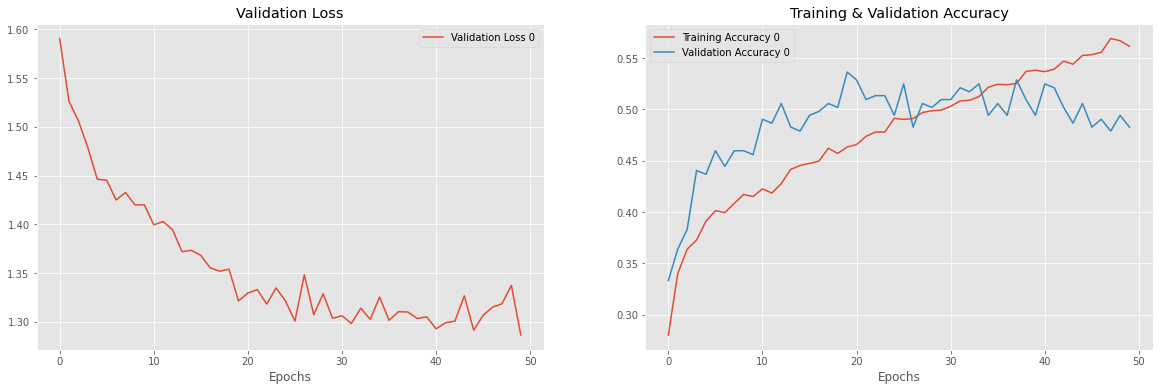

In [ ]:
visualize_loss_and_acc([history], 0)

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(X_test, y_test)[1]*100 , "%")

70/70 [==============================] - 0s 3ms/step - loss: 1.2991 - accuracy: 0.4931 - f1_m: 0.4042
Accuracy of our model on test data :  49.30586516857147 %


In [ ]:
from tensorflow.keras.models import load_model
# model1 = load_model('drive/MyDrive/Assign_Features/best_model', custom_objects={'f1_m':f1_m})

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import classification_report
x = classification_report(y_true, y_pred, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'])
print(x)

              precision    recall  f1-score   support

       angry       0.60      0.71      0.65       386
     disgust       0.48      0.43      0.45       409
        fear       0.38      0.19      0.26       380
       happy       0.41      0.40      0.40       353
     neutral       0.50      0.61      0.55       348
         sad       0.51      0.62      0.56       357

    accuracy                           0.49      2233
   macro avg       0.48      0.50      0.48      2233
weighted avg       0.48      0.49      0.48      2233



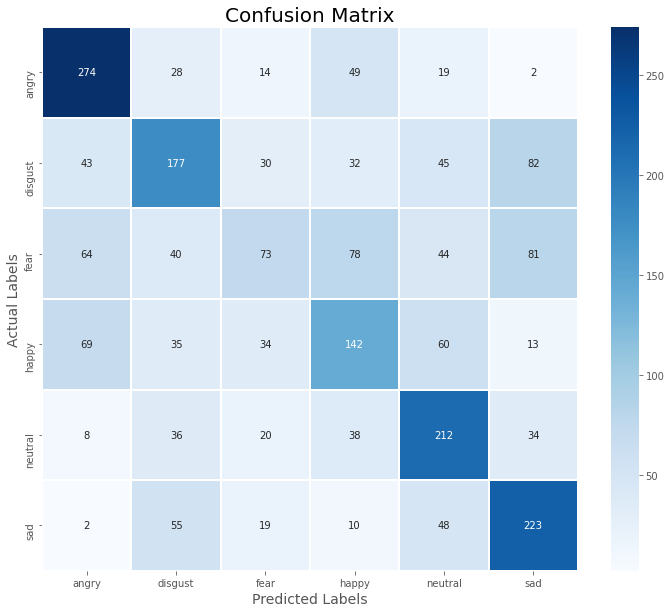

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
array = confusion_matrix(y_true, y_pred)
array
df_cm = pd.DataFrame(array, index = classes,
                    columns = classes)
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Conv2D Model (For melspectrogram)

In [ ]:
def get_2D_model(X_train):
  model = Sequential()
  initializer = initializers.HeUniform()
  weight_decay = regularizers.l2(0)
  model.add(Conv2D(64, kernel_size=(5,5), activation='relu', padding='same', input_shape=(X_train.shape[1:]), kernel_initializer=initializer, kernel_regularizer = weight_decay))
  model.add(BatchNormalization(name="BatchNorm1"))
  model.add(MaxPooling2D(pool_size=(5,5), strides=(2,2), name="MaxPool1"))
  model.add(Conv2D(64, kernel_size=(5,5), activation='relu', padding='same', kernel_initializer=initializer, kernel_regularizer = weight_decay, name="Conv2"))
  model.add(BatchNormalization(name="BatchNorm2"))
  model.add(MaxPooling2D(pool_size=(5,5), strides=(2,2), name="MaxPool2"))
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer=initializer, kernel_regularizer = weight_decay, name="Conv3"))
  model.add(BatchNormalization(name="BatchNorm3"))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name="MaxPool3"))
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer=initializer, kernel_regularizer = weight_decay, name="Conv4"))
  model.add(BatchNormalization(name="BatchNorm4"))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), name="MaxPool4"))
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer=initializer, kernel_regularizer = weight_decay, name="Conv5"))
  model.add(BatchNormalization(name="BatchNorm5"))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name="MaxPool5"))
  model.add(Flatten())
  model.add(Dense(256, activation='relu', kernel_initializer=initializer, kernel_regularizer = weight_decay, name="Dense1"))
  model.add(Dropout(0.5, name="Dropout1"))
  model.add(Dense(128, activation='relu', kernel_initializer=initializer, kernel_regularizer = weight_decay, name="Dense2"))
  model.add(Dropout(0.5, name="Dropout2"))
  model.add(Dense(6, activation='softmax', kernel_initializer=initializer, kernel_regularizer = weight_decay, name="Output_Layer"))
  model.build(input_shape=(X_train.shape))
  opt = optimizers.Adam(0.001)
  model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc", f1_m])
  return model

In [ ]:
model3 = get_2D_model(X_train)
model3.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 108, 128, 64)      1664      
_________________________________________________________________
BatchNorm1 (BatchNormalizati (None, 108, 128, 64)      256       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 52, 62, 64)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 52, 62, 64)        102464    
_________________________________________________________________
BatchNorm2 (BatchNormalizati (None, 52, 62, 64)        256       
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 24, 29, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 24, 29, 64)      

### trying out models

### Best Model for Conv2D

#### The above architecture (but 1st Conv2D layer had kernel_size (10,10)) with initial learning rate 0.00025 with step decay by 0.5 every 10 epochs and no regularization

In [ ]:
model1 = get_2D_model(X_train)
model1.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 108, 128, 64)      6464      
_________________________________________________________________
BatchNorm1 (BatchNormalizati (None, 108, 128, 64)      256       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 52, 62, 64)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 52, 62, 64)        102464    
_________________________________________________________________
BatchNorm2 (BatchNormalizati (None, 52, 62, 64)        256       
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 24, 29, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 24, 29, 64)      

In [ ]:
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64, callbacks = [LRScheduler])

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.00025.
78/78 [==============================] - 9s 84ms/step - loss: 2.9961 - acc: 0.2381 - f1_m: 0.1982 - val_loss: 1.7964 - val_acc: 0.2644 - val_f1_m: 0.0517

Epoch 00001: val_loss improved from inf to 1.79636, saving model to /content/drive/MyDrive/Models/Conv2D_checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00025.
78/78 [==============================] - 6s 75ms/step - loss: 1.6778 - acc: 0.3304 - f1_m: 0.2182 - val_loss: 2.1717 - val_acc: 0.2452 - val_f1_m: 0.2550

Epoch 00002: val_loss did not improve from 1.79636
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00025.
78/78 [==============================] - 6s 75ms/step - loss: 1.5698 - acc: 0.3613 - f1_m: 0.2227 - val_loss: 1.9635 - val_acc: 0.2759 - val_f1_m: 0.2673

Epoch 00003: val_loss did not improve from 1.79636
Epoch 4/30

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00025.
78/78 [==============================] - 6s 75ms/step - loss: 1.5475 - acc: 0.3833 - f1_m: 0.2284 - val_loss: 1.6905 - val_acc: 0.3257 - val_f1_m: 0.1935

Epoch 00004: val_loss improved from 1.79636 to 1.69047, saving model to /content/drive/MyDrive/Models/Conv2D_checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Co

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


Epoch 5/30

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00025.
78/78 [==============================] - 6s 74ms/step - loss: 1.4835 - acc: 0.3981 - f1_m: 0.2488 - val_loss: 1.6050 - val_acc: 0.4138 - val_f1_m: 0.2727

Epoch 00005: val_loss improved from 1.69047 to 1.60495, saving model to /content/drive/MyDrive/Models/Conv2D_checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


Epoch 6/30

Epoch 00006: LearningRateScheduler reducing learning rate to 0.00025.
78/78 [==============================] - 6s 74ms/step - loss: 1.4236 - acc: 0.4438 - f1_m: 0.3013 - val_loss: 1.4804 - val_acc: 0.4100 - val_f1_m: 0.2459

Epoch 00006: val_loss improved from 1.60495 to 1.48038, saving model to /content/drive/MyDrive/Models/Conv2D_checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


Epoch 7/30

Epoch 00007: LearningRateScheduler reducing learning rate to 0.00025.
78/78 [==============================] - 6s 73ms/step - loss: 1.4056 - acc: 0.4285 - f1_m: 0.2841 - val_loss: 1.4483 - val_acc: 0.4215 - val_f1_m: 0.2483

Epoch 00007: val_loss improved from 1.48038 to 1.44826, saving model to /content/drive/MyDrive/Models/Conv2D_checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


Epoch 8/30

Epoch 00008: LearningRateScheduler reducing learning rate to 0.00025.
78/78 [==============================] - 6s 74ms/step - loss: 1.3563 - acc: 0.4668 - f1_m: 0.3220 - val_loss: 1.4128 - val_acc: 0.4253 - val_f1_m: 0.3061

Epoch 00008: val_loss improved from 1.44826 to 1.41283, saving model to /content/drive/MyDrive/Models/Conv2D_checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


Epoch 9/30

Epoch 00009: LearningRateScheduler reducing learning rate to 0.00025.
78/78 [==============================] - 6s 74ms/step - loss: 1.3069 - acc: 0.4889 - f1_m: 0.3657 - val_loss: 1.3910 - val_acc: 0.4521 - val_f1_m: 0.2670

Epoch 00009: val_loss improved from 1.41283 to 1.39102, saving model to /content/drive/MyDrive/Models/Conv2D_checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


Epoch 10/30

Epoch 00010: LearningRateScheduler reducing learning rate to 0.000125.
78/78 [==============================] - 6s 74ms/step - loss: 1.2666 - acc: 0.5031 - f1_m: 0.3832 - val_loss: 1.3701 - val_acc: 0.4713 - val_f1_m: 0.3153

Epoch 00010: val_loss improved from 1.39102 to 1.37011, saving model to /content/drive/MyDrive/Models/Conv2D_checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


Epoch 11/30

Epoch 00011: LearningRateScheduler reducing learning rate to 0.000125.
78/78 [==============================] - 6s 74ms/step - loss: 1.2285 - acc: 0.5219 - f1_m: 0.4185 - val_loss: 1.3696 - val_acc: 0.4674 - val_f1_m: 0.3164

Epoch 00011: val_loss improved from 1.37011 to 1.36961, saving model to /content/drive/MyDrive/Models/Conv2D_checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


Epoch 12/30

Epoch 00012: LearningRateScheduler reducing learning rate to 0.000125.
78/78 [==============================] - 6s 74ms/step - loss: 1.2120 - acc: 0.5366 - f1_m: 0.4303 - val_loss: 1.3780 - val_acc: 0.4521 - val_f1_m: 0.3305

Epoch 00012: val_loss did not improve from 1.36961
Epoch 13/30

Epoch 00013: LearningRateScheduler reducing learning rate to 0.000125.
78/78 [==============================] - 6s 75ms/step - loss: 1.1912 - acc: 0.5364 - f1_m: 0.4352 - val_loss: 1.3597 - val_acc: 0.4789 - val_f1_m: 0.3350

Epoch 00013: val_loss improved from 1.36961 to 1.35968, saving model to /content/drive/MyDrive/Models/Conv2D_checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


Epoch 14/30

Epoch 00014: LearningRateScheduler reducing learning rate to 0.000125.
78/78 [==============================] - 6s 74ms/step - loss: 1.1612 - acc: 0.5478 - f1_m: 0.4557 - val_loss: 1.4334 - val_acc: 0.4138 - val_f1_m: 0.2460

Epoch 00014: val_loss did not improve from 1.35968
Epoch 15/30

Epoch 00015: LearningRateScheduler reducing learning rate to 0.000125.
78/78 [==============================] - 6s 74ms/step - loss: 1.1281 - acc: 0.5628 - f1_m: 0.4798 - val_loss: 1.3451 - val_acc: 0.4904 - val_f1_m: 0.3619

Epoch 00015: val_loss improved from 1.35968 to 1.34509, saving model to /content/drive/MyDrive/Models/Conv2D_checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


Epoch 16/30

Epoch 00016: LearningRateScheduler reducing learning rate to 0.000125.
78/78 [==============================] - 6s 74ms/step - loss: 1.1110 - acc: 0.5653 - f1_m: 0.4970 - val_loss: 1.3706 - val_acc: 0.4943 - val_f1_m: 0.3605

Epoch 00016: val_loss did not improve from 1.34509
Epoch 17/30

Epoch 00017: LearningRateScheduler reducing learning rate to 0.000125.
78/78 [==============================] - 6s 74ms/step - loss: 1.0889 - acc: 0.5961 - f1_m: 0.4994 - val_loss: 1.4053 - val_acc: 0.4751 - val_f1_m: 0.3742

Epoch 00017: val_loss did not improve from 1.34509
Epoch 18/30

Epoch 00018: LearningRateScheduler reducing learning rate to 0.000125.
78/78 [==============================] - 6s 74ms/step - loss: 1.0605 - acc: 0.6012 - f1_m: 0.5344 - val_loss: 1.3603 - val_acc: 0.4828 - val_f1_m: 0.4015

Epoch 00018: val_loss did not improve from 1.34509
Epoch 19/30

Epoch 00019: LearningRateScheduler reducing learning rate to 0.000125.
78/78 [==============================] - 6s 74

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/Conv2D_checkpoint/assets


Epoch 21/30

Epoch 00021: LearningRateScheduler reducing learning rate to 6.25e-05.
78/78 [==============================] - 6s 74ms/step - loss: 0.9645 - acc: 0.6392 - f1_m: 0.5796 - val_loss: 1.3614 - val_acc: 0.5249 - val_f1_m: 0.4055

Epoch 00021: val_loss did not improve from 1.34202
Epoch 22/30

Epoch 00022: LearningRateScheduler reducing learning rate to 6.25e-05.
78/78 [==============================] - 6s 74ms/step - loss: 0.9232 - acc: 0.6523 - f1_m: 0.5997 - val_loss: 1.3958 - val_acc: 0.4751 - val_f1_m: 0.4280

Epoch 00022: val_loss did not improve from 1.34202
Epoch 23/30

Epoch 00023: LearningRateScheduler reducing learning rate to 6.25e-05.
78/78 [==============================] - 6s 73ms/step - loss: 0.9035 - acc: 0.6638 - f1_m: 0.6187 - val_loss: 1.3793 - val_acc: 0.4713 - val_f1_m: 0.3989

Epoch 00023: val_loss did not improve from 1.34202
Epoch 24/30

Epoch 00024: LearningRateScheduler reducing learning rate to 6.25e-05.
78/78 [==============================] - 6s 74

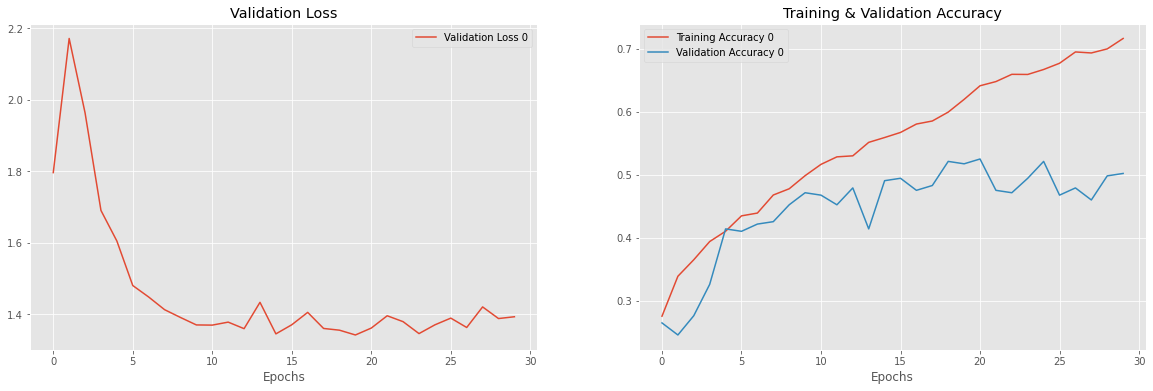

In [ ]:
visualize_loss_and_acc([history], 0)

In [ ]:
print("Accuracy of our model on test data : " , model1.evaluate(X_test, y_test)[1]*100 , "%")

70/70 [==============================] - 1s 17ms/step - loss: 1.0955 - acc: 0.6019 - f1_m: 0.5675
Accuracy of our model on test data :  60.188084840774536 %


In [ ]:
from tensorflow.keras.models import load_model
# model1 = load_model('drive/MyDrive/Assign_Features/best_model', custom_objects={'f1_m':f1_m})

y_pred1 = model1.predict(X_test)
y_predx = np.argmax(y_pred1, axis=1)
y_true = np.argmax(y_test, axis=1)

In [ ]:

from sklearn.metrics import classification_report
x = classification_report(y_true, y_predx, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'])
print(x)

              precision    recall  f1-score   support

       angry       0.70      0.76      0.73       376
     disgust       0.55      0.41      0.47       371
        fear       0.57      0.48      0.52       398
       happy       0.60      0.61      0.60       374
     neutral       0.67      0.66      0.67       329
         sad       0.53      0.70      0.61       385

    accuracy                           0.60      2233
   macro avg       0.60      0.60      0.60      2233
weighted avg       0.60      0.60      0.60      2233



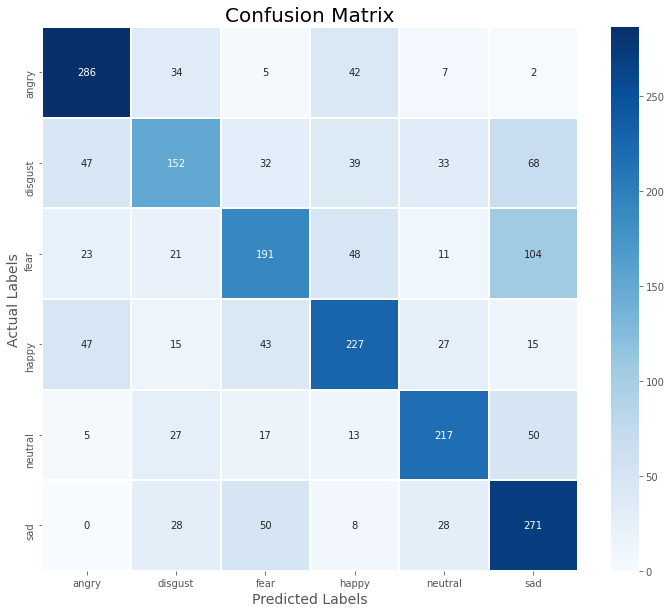

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
array = confusion_matrix(y_true, y_predx)
array
df_cm = pd.DataFrame(array, index = classes,
                    columns = classes)
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

#### The above architecture with intial learning rate 0.00085 with reducing on plateau callback and l2 regularization of 0.001

In [ ]:
model2 = get_2D_model(X_train)
model2.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 108, 128, 64)      1664      
_________________________________________________________________
BatchNorm1 (BatchNormalizati (None, 108, 128, 64)      256       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 52, 62, 64)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 52, 62, 64)        102464    
_________________________________________________________________
BatchNorm2 (BatchNormalizati (None, 52, 62, 64)        256       
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 24, 29, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 24, 29, 64)      

In [ ]:
history = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks = [reduce_on_plateau])

Epoch 1/20
155/155 [==============================] - 8s 36ms/step - loss: 4.2671 - acc: 0.2710 - f1_m: 0.2030 - val_loss: 4.7165 - val_acc: 0.2261 - val_f1_m: 0.2508
Epoch 2/20
155/155 [==============================] - 5s 32ms/step - loss: 3.1812 - acc: 0.3504 - f1_m: 0.2016 - val_loss: 3.8784 - val_acc: 0.2682 - val_f1_m: 0.2440
Epoch 3/20
155/155 [==============================] - 5s 32ms/step - loss: 3.0252 - acc: 0.3868 - f1_m: 0.2289 - val_loss: 3.0786 - val_acc: 0.3640 - val_f1_m: 0.2762
Epoch 4/20
155/155 [==============================] - 5s 32ms/step - loss: 2.8950 - acc: 0.4239 - f1_m: 0.2534 - val_loss: 2.8058 - val_acc: 0.4406 - val_f1_m: 0.3265
Epoch 5/20
155/155 [==============================] - 5s 31ms/step - loss: 2.7251 - acc: 0.4595 - f1_m: 0.3192 - val_loss: 2.6832 - val_acc: 0.4521 - val_f1_m: 0.2364
Epoch 6/20
155/155 [==============================] - 5s 31ms/step - loss: 2.6053 - acc: 0.4634 - f1_m: 0.3247 - val_loss: 2.4973 - val_acc: 0.5057 - val_f1_m: 0.358

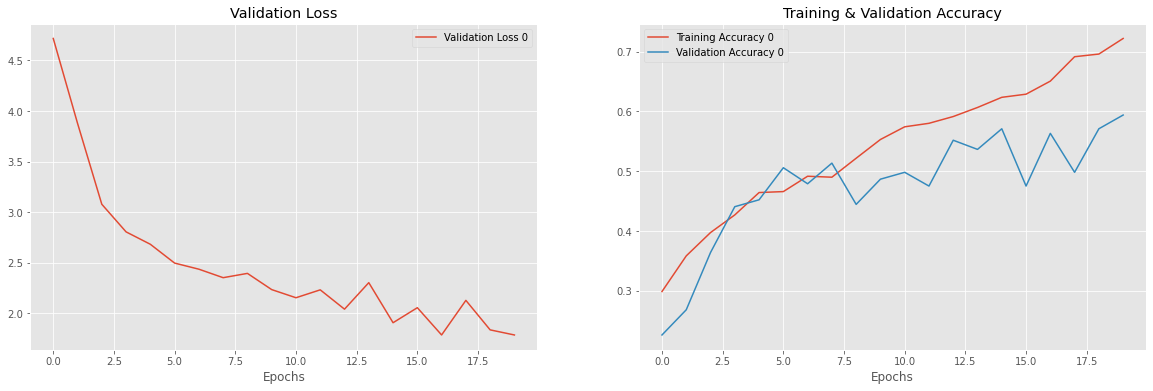

In [ ]:
visualize_loss_and_acc([history], 0)

In [ ]:
print("Accuracy of our model on test data : " , model2.evaluate(X_test, y_test)[1]*100 , "%")

70/70 [==============================] - 1s 13ms/step - loss: 1.6803 - acc: 0.6185 - f1_m: 0.5797
Accuracy of our model on test data :  61.84505224227905 %


In [ ]:
y_pred2 = model2.predict(X_test)
y_predx = np.argmax(y_pred2, axis=1)
y_true = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import classification_report
x = classification_report(y_true, y_predx, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'])
print(x)

              precision    recall  f1-score   support

       angry       0.68      0.83      0.75       392
     disgust       0.48      0.65      0.55       371
        fear       0.68      0.38      0.49       377
       happy       0.70      0.52      0.59       390
     neutral       0.63      0.75      0.68       304
         sad       0.62      0.61      0.61       399

    accuracy                           0.62      2233
   macro avg       0.63      0.62      0.61      2233
weighted avg       0.63      0.62      0.61      2233



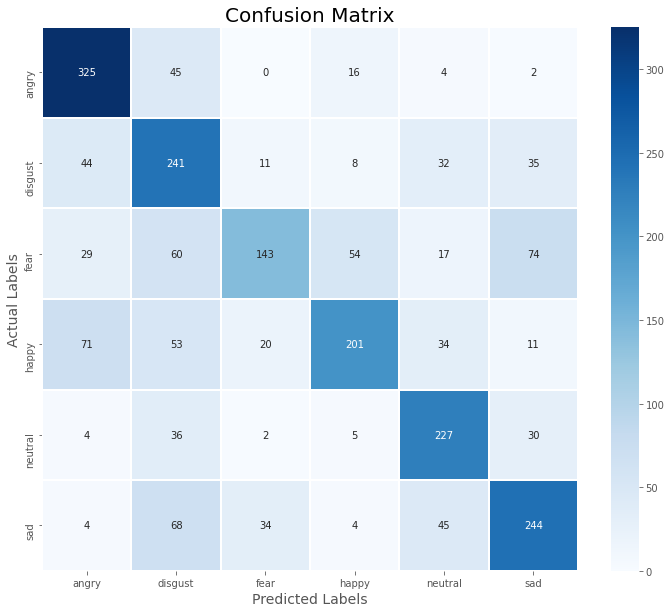

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
array = confusion_matrix(y_true, y_predx)
array
df_cm = pd.DataFrame(array, index = classes,
                    columns = classes)
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

#### The above architecture (but 1st Conv2D layer had kernel_size (10,10)) with initial learning rate 0.001 with step decay by 0.5 every 7 epochs and no regularization

In [ ]:
model3 = get_2D_model(X_train)
model3.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 108, 128, 64)      1664      
_________________________________________________________________
BatchNorm1 (BatchNormalizati (None, 108, 128, 64)      256       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 52, 62, 64)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 52, 62, 64)        102464    
_________________________________________________________________
BatchNorm2 (BatchNormalizati (None, 52, 62, 64)        256       
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 24, 29, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 24, 29, 64)      

In [ ]:
history = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64, callbacks = [LRScheduler])

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
78/78 [==============================] - 9s 81ms/step - loss: 2.0195 - acc: 0.3188 - f1_m: 0.2321 - val_loss: 1.9052 - val_acc: 0.2299 - val_f1_m: 0.0223
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
78/78 [==============================] - 6s 72ms/step - loss: 1.4125 - acc: 0.4337 - f1_m: 0.3010 - val_loss: 2.7584 - val_acc: 0.1762 - val_f1_m: 0.2394
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
78/78 [==============================] - 6s 73ms/step - loss: 1.3521 - acc: 0.4682 - f1_m: 0.3484 - val_loss: 2.4283 - val_acc: 0.2261 - val_f1_m: 0.2561
Epoch 4/30

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
78/78 [==============================] - 6s 73ms/step - loss: 1.3017 - acc: 0.4844 - f1_m: 0.3763 - val_loss: 1.7944 - val_acc: 0.3218 - val_f1_m: 0.3284
Epoch 5/30

Epoch 00005: LearningRateScheduler reducing learning

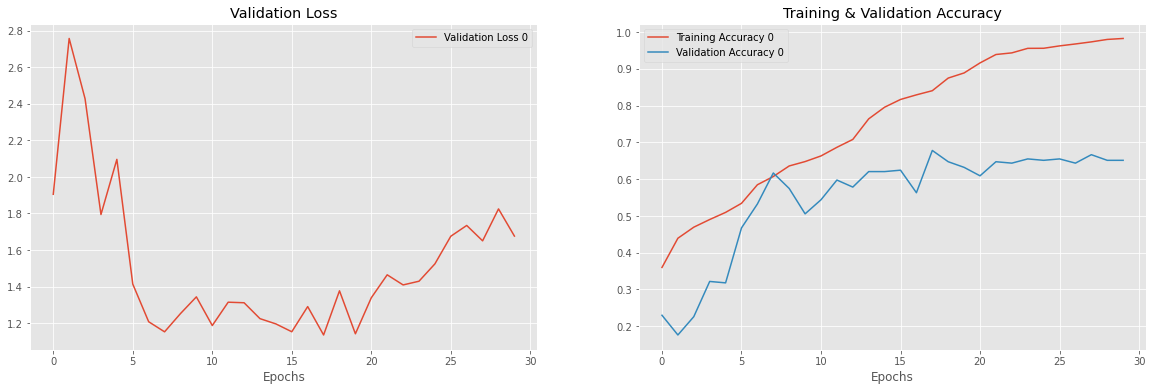

In [ ]:
visualize_loss_and_acc([history], 0)

In [ ]:
print("Accuracy of our model on test data : " , model3.evaluate(X_test, y_test)[1]*100 , "%")

70/70 [==============================] - 1s 17ms/step - loss: 1.9788 - acc: 0.6171 - f1_m: 0.6152
Accuracy of our model on test data :  61.71070337295532 %


In [ ]:
y_pred3 = model3.predict(X_test)
y_predx = np.argmax(y_pred3, axis=1)
y_true = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import classification_report
x = classification_report(y_true, y_predx, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'])
print(x)

              precision    recall  f1-score   support

       angry       0.77      0.71      0.74       388
     disgust       0.57      0.55      0.56       396
        fear       0.60      0.56      0.58       387
       happy       0.60      0.58      0.59       376
     neutral       0.64      0.72      0.68       326
         sad       0.53      0.61      0.56       360

    accuracy                           0.62      2233
   macro avg       0.62      0.62      0.62      2233
weighted avg       0.62      0.62      0.62      2233



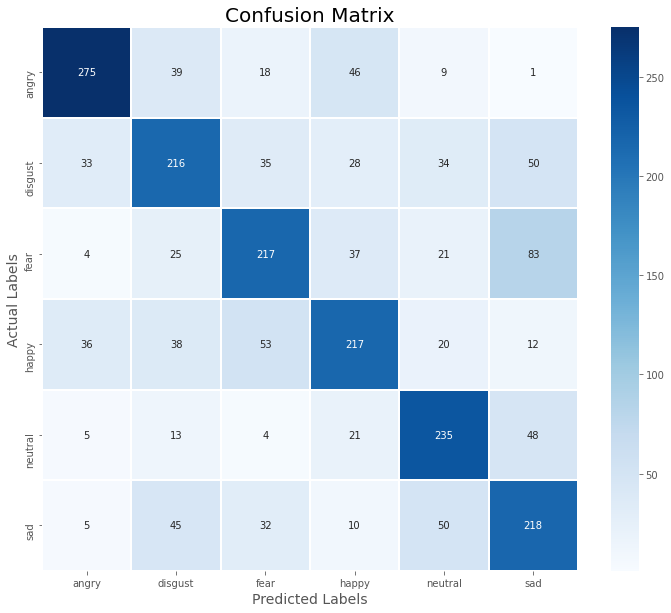

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
array = confusion_matrix(y_true, y_predx)
array
df_cm = pd.DataFrame(array, index = classes,
                    columns = classes)
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

## Ensemble

In [ ]:
from scipy.stats import mode
y_pred = []
for i in range(len(y_test)):
  x = [np.argmax(y_pred1, axis=1)[i], np.argmax(y_pred2, axis=1)[i], np.argmax(y_pred3, axis=1)[i]]
  ens = mode(x)[0][0]
  y_pred.append(ens)

In [ ]:
y_true = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
x = classification_report(y_true, y_pred, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'])
print(x)

              precision    recall  f1-score   support

       angry       0.71      0.82      0.76       392
     disgust       0.63      0.54      0.58       371
        fear       0.58      0.55      0.57       377
       happy       0.65      0.56      0.60       390
     neutral       0.67      0.78      0.72       304
         sad       0.61      0.64      0.63       399

    accuracy                           0.64      2233
   macro avg       0.64      0.65      0.64      2233
weighted avg       0.64      0.64      0.64      2233



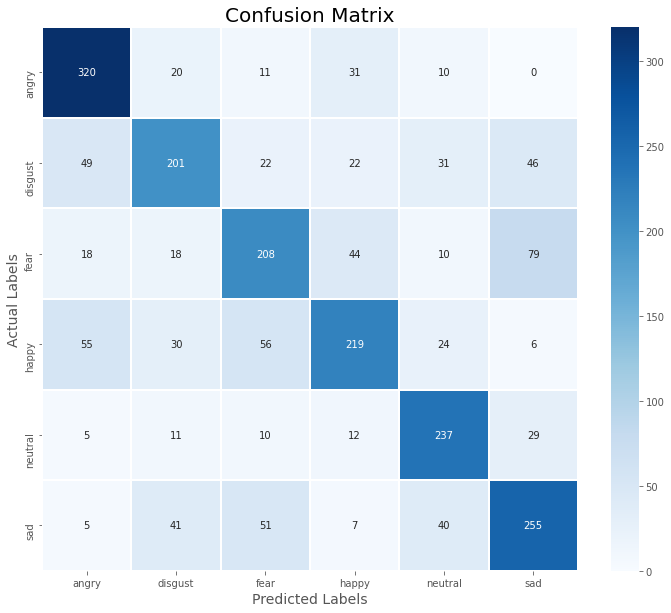

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
array = confusion_matrix(y_true, y_pred)
array
df_cm = pd.DataFrame(array, index = classes,
                    columns = classes)
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()